# Zestaw zadań: Równania różniczkowe - spectral bias
## Zadanie 1
### Autor: Artur Gęsiarz

In [18]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

### Definicja analitycznego rozwiązania

In [19]:
def exact_solution(x, w):
    return (1/w) * torch.sin(w * x)

### Definicja sieci neuronowej

In [20]:
class FCN(nn.Module):
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

### Funkcja obliczajca koszt warunku poczatkowego

In [21]:
def calculate_cond_start_cost(model, x_boundary):
    u0 = model(x_boundary)
    loss_ic = u0 ** 2
    return  loss_ic

### Funkcja obliczajca koszt rezydualny

In [22]:
def calculate_residual_cost(model, x_physics, w):
    u = model(x_physics)
    du_dx = torch.autograd.grad(u, x_physics, torch.ones_like(u), create_graph=True)[0]
    residual = du_dx - torch.cos(w * x_physics)
    loss_r = torch.mean(residual**2)
    return loss_r

### Funkcja obliczajca koszt totalny

In [23]:
def calculate_total_cost(model, x_boundary, x_physics, w):
    return calculate_cond_start_cost(model, x_boundary) + calculate_residual_cost(model, x_physics, w)

### Funkcja treningowa PINN

In [24]:
def train_PINN(model: FCN, x_boundary, x_physics, w, epochs=50000, lr=0.001):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    losses = []

    for i in range(epochs):
        optimizer.zero_grad()

        loss = calculate_total_cost(model, x_boundary, x_physics, w)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()

        if i % 5000 == 0:
            print(f'Epoch {i}, Loss: {loss.item()}')

    return losses

### Funkcja do rysowania wyników

In [25]:
def plot_results(x_test, u_exact, u_pred, losses, title):

    plt.plot(x_test, u_exact, label='Exact solution')
    plt.plot(x_test, u_pred, '--', label='PINN solution')
    plt.xlabel('x')
    plt.ylabel('u(x)')
    plt.title('Solution')
    plt.legend()
    plt.show()

    plt.plot(x_test, abs((u_exact - u_pred)))
    plt.xlabel('?')
    plt.ylabel('?')
    plt.title('Error function')
    plt.show()

    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.show()

### Stałe w naszym modelu

In [26]:
N_INPUT = 1
N_OUTPUT = 1
LR = 0.001
EPOCHS = 50000

### a) Przypadek $ \omega = 1$

### Parametry naszego modelu

In [27]:
N_LAYERS = 2
N_HIDDEN = 16
TRAINING_POINTS = 200
TESTING_POINTS = 1000
OMEGA = 1

### Definicja modelu

In [28]:
model = FCN(N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS)

### Definicja punktów treningowych i testowych

In [29]:
x_boundary = torch.tensor([[0.0]], requires_grad=True)
x_physics = torch.linspace(-2 * np.pi, 2 * np.pi, TRAINING_POINTS).view(-1, 1).requires_grad_(True)
x_test = torch.linspace(-2 * np.pi, 2 * np.pi, TESTING_POINTS).view(-1, 1)
u_exact = exact_solution(x_test, OMEGA)

### Trening modelu

In [30]:
print(f'Training for w = {OMEGA}, Layers = {N_LAYERS}, Neurons = {N_HIDDEN}\n')
losses = train_PINN(model, x_boundary, x_physics, OMEGA, EPOCHS, LR)

Training for w = 1, Layers = 2, Neurons = 16

Epoch 0, Loss: 0.49222156405448914
Epoch 5000, Loss: 1.8885206372942775e-05
Epoch 10000, Loss: 4.814702151634265e-06
Epoch 15000, Loss: 1.612670166650787e-05
Epoch 20000, Loss: 2.1563200789387338e-05
Epoch 25000, Loss: 3.96803534385981e-06
Epoch 30000, Loss: 1.407809918418934e-06
Epoch 35000, Loss: 1.2494147995312233e-05
Epoch 40000, Loss: 1.189784143207362e-06
Epoch 45000, Loss: 1.1309532510495046e-06


### Zapisywanie treningu do osobnego pliku

In [31]:
torch.save(model, "models/model_a_2_16.pth")

### Wczytywanie treningu z pliku

In [32]:
model_load = torch.load("models/model_a_2_16.pth")

### Przewidywanie wartości

In [33]:
u_pred = model_load(x_test).detach().numpy()
u_exact = u_exact.numpy()

### Rysowanie wynikow

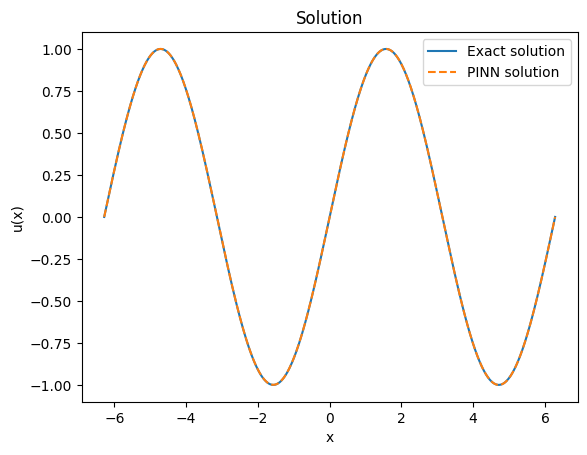

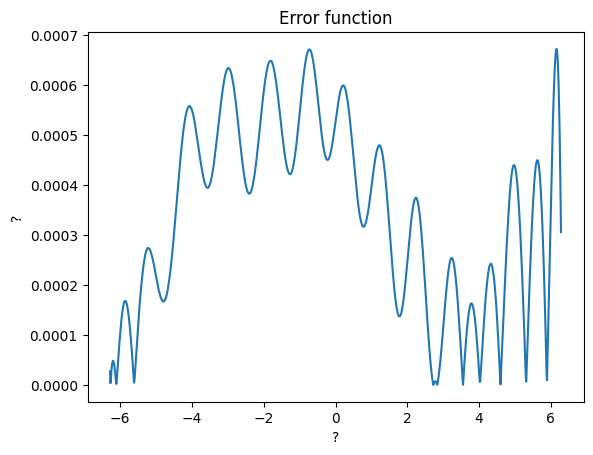

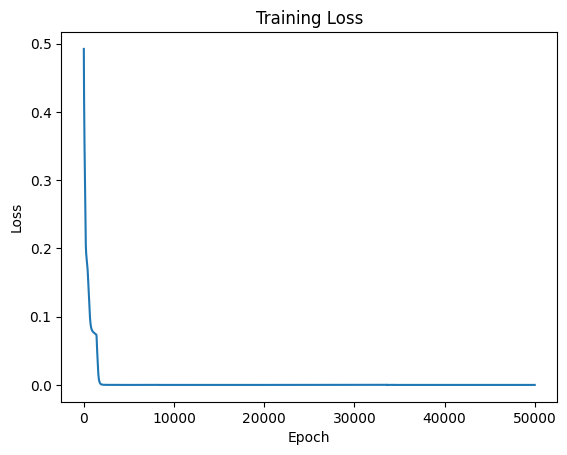

In [34]:
plot_results(x_test, u_exact, u_pred, losses, f'w = {OMEGA}, Layers = {N_LAYERS}, Neurons = {N_HIDDEN}')

### b) Przypadek $ \omega = 15$

### Parametry naszego modelu

In [35]:
TRAINING_POINTS = 3000
TESTING_POINTS = 5000
OMEGA = 15
ARCH = [(2,16), (4,64), (5,128)]

### Def. modelu, def. pkt. treningowych, def. pkt. testowych, trenig, przewidywanie wartosci, rysowanie...

In [36]:
# for N_LAYERS, N_HIDDEN in ARCH:
#
#     # Definicja modelu
#     model = FCN(N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS)
#
#     # Definicja punktów treningowych i testowych
#     x_boundary = torch.tensor([[0.0]], requires_grad=True)
#     x_physics = torch.linspace(-2 * np.pi, 2 * np.pi, TRAINING_POINTS).view(-1, 1).requires_grad_(True)
#     x_test = torch.linspace(-2 * np.pi, 2 * np.pi, TESTING_POINTS).view(-1, 1)
#     u_exact = exact_solution(x_test, OMEGA)
#
#     # Trening
#     print(f'Training for w = {OMEGA}, Layers = {N_LAYERS}, Neurons = {N_HIDDEN}\n')
#     losses = train_PINN(model, x_boundary, x_physics, OMEGA, EPOCHS, LR)
#
#     # Zapis
#     torch.save(model, f"models/model_b_{N_LAYERS}_{N_HIDDEN}.pth")
#
#     # Odczyt
#     model_load = torch.load(f"models/model_b_{N_LAYERS}_{N_HIDDEN}.pth")
#
#     # Przewidywanie wartości
#     u_pred = model(x_test).detach().numpy()
#     u_exact = u_exact.numpy()
#
#     # Rysowanie wykresow
#     plot_results(x_test, u_exact, u_pred, losses, f'w = {OMEGA}, Layers = {N_LAYERS}, Neurons = {N_HIDDEN}')

### c) Przypadek